In [1]:
""" Classes and examples for searching for flights using SkyPicker. """
from __future__ import unicode_literals, absolute_import, generators, \
    print_function

import requests
from datetime import datetime, timedelta, date, time

#import datetime
import time
import numpy as np
import json
import pandas as pd
import ephem

### for the geodesic module later on down
import os
import math
import logging
from pyproj import Geod
from shapely.geometry import LineString, mapping
from fiona import collection
from fiona.transform import transform_geom
from fiona.crs import from_epsg

### make the globe
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import aacgmv2

In [2]:
class SkyPickerApi(object):
    """ SkyPicker API. """
    def __init__(self):
        """ Initializes the API object with URL attributes. """
        self.base_url = 'https://api.skypicker.com/'
        self.path = ''
        self.param_str = ''

    @property
    def full_url(self):
        """ Returns the full URL for requesting the data. """
        return '{}{}{}'.format(self.base_url, self.path, self.param_str)

    def get_request(self):
        """ Requests the API endpoint and returns the response """
        headers = {'content-type': 'application/json'}
        resp = requests.get(self.full_url, headers=headers)
        return resp.json()
    

    def search_places(self, place_name, locale=None):
        """ Finds matching place API ids to use for searches.
        :param place_name: string of the place name to search for
        :kwarg locale: two letter lowercase locale string

        returns JSON response
        """
        self.path = 'places'
        self.param_str = '?term={}&partner=picky'.format(place_name)
        if locale:
            self.param_str += '&locale={}'.format(locale)
        return self.get_request()
    
    def search_airports(self, iata_code, locale=None):
        """ gets lon and lat of given airport
        returns JSON response
        """
        self.path = 'locations'
        self.param_str = '?term={}&partner=picky'.format(iata_code)
        if locale:
            self.param_str += '&locale={}'.format(locale)
        return self.get_request()

    def search_flights(self, origin, start_date, end_date):
        """ Searches for direct flights given a time range and origin airport code.
        :param origin: string representing the ID or IATA
        :param start_date: datetime representing first possible travel date
        :param end_date: datetime representing last possible travel date

        returns JSON response
        """
        self.path = 'flights'
        self.param_str = '?flyFrom={}&dateFrom={}&dateTo={}&directFlights={}&partner=picky'.format(
                origin, start_date.strftime('%d/%m/%Y'),
                end_date.strftime('%d/%m/%Y'),1)

        resp = self.get_request()
        flights = []
        for flight in resp.get('data'):
            flight_info = {
                'departure': datetime.utcfromtimestamp(flight.get('dTimeUTC')),
                'arrival': datetime.utcfromtimestamp(flight.get('aTimeUTC')),
                'price': flight.get('price'),
                'currency': resp.get('currency'),
                'legs': []
            }
            flight_info['duration'] = flight_info['arrival'] - \
                flight_info['departure']
            flight_info['duration_hours'] = (flight_info[
                'duration'].total_seconds() / 60.0) / 60.0
            for route in flight['route']:
                flight_info['legs'].append({
                    'carrier': route['airline'],
                    'departure': datetime.utcfromtimestamp(
                        route.get('dTimeUTC')),
                    'arrival': datetime.utcfromtimestamp(
                        route.get('aTimeUTC')),
                    'from': '{} ({})'.format(route['cityFrom'],
                                             route['flyFrom']),
                    'to': '{} ({})'.format(route['cityTo'], route['flyTo']),
                })
            flight_info['carrier'] = ', '.join(set([c.get('carrier') for c
                                                    in flight_info['legs']]))
            flights.append(flight_info)
        return flights

In [3]:
origin = 'MUC'    #origin airport IATA code

arctic_circle_lat = 64.0   #it's actually 66.3 degrees, but give a bit of wiggle room





In [4]:
### query SkyPicker API to get all direct flights from this airport over a 1-week period
current_date = time.strftime('%m/%d/%Y')
sp_api = SkyPickerApi()
sp_results = sp_api.search_flights(origin, datetime.strptime(current_date, '%m/%d/%Y')+timedelta(days=7),
                                       datetime.strptime(current_date, '%m/%d/%Y')+timedelta(days=14))


In [5]:
### find the unique destination airports among all direct flights
dest_iata_codes = []
for i in range(len(sp_results)):
    dest_iata_code = sp_results[i]['legs'][0]['to'][-4:-1]
    dest_iata_codes.append(dest_iata_code)
    
unique_dest_iata_codes = set(dest_iata_codes)
print(unique_dest_iata_codes)

{'CFU', 'CDG', 'BLQ', 'FMO', 'RZE', 'BHX', 'PMO', 'DME', 'MXP', 'NTE', 'DTW', 'SZF', 'AOI', 'GPA', 'PRN', 'BJV', 'WDH', 'HEL', 'EWR', 'DLM', 'PEK', 'SCN', 'MBX', 'PRG', 'AMM', 'BRQ', 'SBZ', 'YYZ', 'LAX', 'BDS', 'SCQ', 'OPO', 'ORD', 'KGS', 'LEJ', 'ADB', 'JMK', 'BOS', 'VLC', 'ANR', 'HRG', 'BEG', 'ICN', 'AUH', 'PHL', 'KEF', 'TBS', 'DBV', 'BOM', 'WRO', 'TXL', 'RHO', 'ATH', 'LIS', 'KLX', 'FCO', 'AYT', 'FRA', 'SKG', 'RUH', 'OVD', 'CGN', 'TRS', 'GOA', 'BUD', 'MAD', 'CTA', 'BKK', 'JSH', 'GRQ', 'KTW', 'LCJ', 'GLA', 'KWI', 'IBZ', 'MLA', 'MJT', 'CUN', 'JSI', 'MAH', 'EBL', 'ESB', 'WAW', 'BSL', 'ZRH', 'TIV', 'SOF', 'YUL', 'DXB', 'ALC', 'STN', 'BOD', 'MCT', 'RJK', 'OSL', 'DEB', 'JER', 'TLL', 'SFO', 'BRN', 'ZAD', 'MEX', 'PAD', 'SJJ', 'STR', 'AAR', 'EFL', 'VOL', 'CPH', 'ADA', 'AGA', 'DRS', 'CAI', 'TLV', 'VNO', 'LYS', 'LWO', 'PUY', 'POZ', 'IAH', 'SVQ', 'GOT', 'VCE', 'GWT', 'VIE', 'GRZ', 'CLT', 'YVR', 'MAN', 'LJU', 'BRI', 'KRK', 'TFS', 'AGP', 'IAS', 'SMI', 'SPU', 'LCA', 'RIX', 'CHQ', 'TIA', 'DUS', 'DOH'

In [6]:
def get_airport_coords(sp_api,iata_code):
    ### returns the latitude and longitude of a given airport,
    ### identified by its IATA code
    ### sp_api - an instance of the SkyPicker API
    ### iata_code - an IATA code for an airport
    lat = None; lon = None;  #reset values
    airport_results = sp_api.search_airports(iata_code)
    for airport_result in airport_results['locations']:
        if airport_result['id'] != iata_code:
            continue
        lat = airport_result['location']['lat']
        lon = airport_result['location']['lon']
    return lat,lon


In [7]:
### get latitudes and longitudes for all unique destination airports
### by querying SkyPicker API
sp_loc_api = SkyPickerApi()
unique_dest_lons = []
unique_dest_lats = []
        
for iata_code in unique_dest_iata_codes:
    lat,lon = get_airport_coords(sp_api,iata_code)
    unique_dest_lats.append(lat)
    unique_dest_lons.append(lon)

In [8]:
### get latitude and longitude for origin airport as well
origin_lat,origin_lon = get_airport_coords(sp_api,origin)


In [9]:
### put the destination airport names (IATA code) and coordinates into a pandas dataframa
dest_airports = pd.DataFrame(data=np.transpose([list(unique_dest_iata_codes),unique_dest_lons,unique_dest_lats]),
                                    columns=['code','lon','lat'])

In [10]:
#dest_airports

In [11]:
### This is a dump of the code from the GeodesicLinesToGIS module, which I cannot import 
### for some reason due to circular dependencies.
### source: https://github.com/GeographicaGS/GeodesicLinesToGIS/blob/master/geodesiclinestogis/geodesicline2gisfile.py

class ComputeGeodesicLineError(Exception):
    pass

class ExportGeodesicLineError(Exception):
    pass

class GeodesicLine2Gisfile(object):

    def __init__(self, antimeridian=True, loglevel="INFO"):
        """
            antimeridian: solving antimeridian problem [True/False].
            prints: print output messages [True/False].
        """
        self.__antimeridian = antimeridian
        self.__logger = self.__loggerInit(loglevel)
        self.__distances = []


    def __loggerInit(self, loglevel):
        """
        Logger init...
        """
        if loglevel=="INFO":
            __log_level=logging.INFO
        elif loglevel=="DEBUG":
            __log_level=logging.DEBUG
        elif loglevel=="ERROR":
            __log_level=logging.ERROR
        else:
            __log_level=logging.NOTSET

        logfmt = "[%(asctime)s - %(levelname)s] - %(message)s"
        dtfmt = "%Y-%m-%d %I:%M:%S"

        logging.basicConfig(level=__log_level, format=logfmt, datefmt=dtfmt)

        return logging.getLogger()
    
    @property
    def distances(self):
        return self.__distances
    
    def __dest_folder(self, dest, crtfld):
        if not os.path.exists(dest):
            if not crtfld:
                self.__logger.error("Output folder does not exist. Set a valid folder path to store file.")
                return
            os.mkdir(dest)
            self.__logger.debug("New output folder {0} created.".format(dest))
        else:
            self.__logger.debug("Output folder {0} already exists.".format(dest))

    def gdlComp(self, lons_lats, km_pts=20):
        """
        Compute geodesic line
            lons_lats: input coordinates.
            (start longitude, start latitude, end longitude, end latitude)
            km_pts: compute one point each 20 km (default).
        """

        try:
            lon_1, lat_1, lon_2, lat_2 = lons_lats

            pygd = Geod(ellps='WGS84')

            res = pygd.inv(lon_1, lat_1, lon_2, lat_2)
            dist = res[2]

            pts  = int(math.ceil(dist) / (km_pts * 1000))

            coords = pygd.npts(lon_1, lat_1, lon_2, lat_2, pts)

            coords_se = [(lon_1, lat_1)] + coords
            coords_se.append((lon_2, lat_2))
            
            self.__distances.append({
                "id": len(self.__distances),
                "distance": dist,
                "coords": lons_lats
            })
            
            self.__logger.info("Geodesic line succesfully created!")
            self.__logger.info("Total points = {:,}".format(pts))
            self.__logger.info("{:,.4f} km".format(dist / 1000.))

            return coords_se

        except Exception as e:
            self.__logger.error("Error: {0}".format(e))
            raise ComputeGeodesicLineError(e)


    def gdlToGisFile(self, coords, folderpath, layername, fmt="ESRI Shapefile",
                     epsg_cd=4326, prop=None, crtfld=True):
        """
        Dump geodesic line coords to ESRI Shapefile
        and GeoJSON Linestring Feature
            coords: input coords returned by gcComp.
            folderpath: folder to store output file.
            layername: output filename.
            fmt: output format ("ESRI Shapefile" (default), "GeoJSON").
            epsg_cd: Coordinate Reference System, EPSG code (default: 4326)
            prop: property
            
            crtfld: create folder if not exists (default: True).
        """

        schema = { 'geometry': 'LineString',
                   'properties': { 'prop': 'str' }
                   }

        try:

            if fmt in ["ESRI Shapefile", "GeoJSON"]:
                ext = ".shp"
                if fmt == "GeoJSON":
                    ext = ".geojson"

                filepath = os.path.join(folderpath, "{0}{1}".format(layername, ext))

                self.__dest_folder(folderpath, crtfld)

                if fmt == "GeoJSON" and os.path.isfile(filepath):
                    os.remove(filepath)

                out_crs = from_epsg(epsg_cd)

                with collection(filepath, "w", fmt, schema, crs=out_crs) as output:

                    line = LineString(coords)

                    geom = mapping(line)

                    if self.__antimeridian:
                        line_t = self.__antiMeridianCut(geom)
                    else:
                        line_t = geom

                    output.write({
                        'properties': {
                            'prop': prop
                        },
                        'geometry': line_t
                    })

                self.__logger.info("{0} succesfully created!".format(fmt))

            else:
                self.__logger.error("No format to store output...")
                return

        except Exception as e:
            self.__logger.error("Error: {0}".format(e))
            raise ExportGeodesicLineError(e)


    def gdlToGisFileMulti(self, data, folderpath, layername, prop=[], gjs=True):
        """
        Run creation for a multi input: a list of lat/lon.
            data: a list with input coordinates.
            [
              (start longitude, start latitude, end longitude, end latitude),
              (start longitude, start latitude, end longitude, end latitude),
              (start longitude, start latitude, end longitude, end latitude),
              (start longitude, start latitude, end longitude, end latitude),
              ...
            ]
            folderpath: folder to store output files.
            layername: output base filename (an ordinal integer is added at the end).
            gfs: GeoJSON output format [True (default)|False], in addition to Shapefile.
        """

        try:
            lendata = len(data)

            for i in range(lendata):
                lyrnm = "{0}{1}".format(layername, i)
                _prop = prop[i] if prop else None
                self.__multiGeodesicLineCreation(data[i], folderpath, lyrnm, gjs, _prop)

        except Exception as e:
            self.__logger.error("Error: {0}".format(e))
            raise ExportGeodesicLineError(e)


    def __multiGeodesicLineCreation(self, lons_lats, folderpath, layername, gjs, prop):
        """
        Creating geodesic lines in batch mode
        """

        cd = self.gdlComp(lons_lats)

        self.gdlToGisFile(cd, folderpath, layername, prop=prop)

        if gjs:
            self.gdlToGisFile(cd, folderpath, layername, fmt="GeoJSON")


    def __antiMeridianCut(self, geom):
        """
        Solving antimeridian problem.
        """

        src_crs = '+proj=longlat +datum=WGS84 +no_defs'
        dst_crs = '+proj=longlat +datum=WGS84 +no_defs'

        am_offset = 360.0

        line_t = transform_geom(src_crs, dst_crs, geom,
                                antimeridian_cutting=self.__antimeridian,
                                antimeridian_offset=am_offset,
                                precision=-1)

        return line_t

In [12]:
### create the does_this_route_pass_through_arctic np.array, 
### which is zero if a given route does not pass through the Arctic
### and which is one if the route does pass through the Arctic

if origin_lat > arctic_circle_lat:
    does_this_route_pass_through_arctic = np.ones(len(dest_airports))
else:
    does_this_route_pass_through_arctic = np.zeros(len(dest_airports))
    for i in range(len(dest_airports)):
        folderpath = '/Users/michevan/Desktop/insight/gis'
        layername = origin+'-'+dest_airports.loc[i].code
        gtg = GeodesicLine2Gisfile()
        lons_lats = (origin_lon, origin_lat, np.float(dest_airports.loc[i].lon), np.float(dest_airports.loc[i].lat))
        cd = gtg.gdlComp(lons_lats, km_pts=10)
        gtg.gdlToGisFile(cd, folderpath, layername, fmt="GeoJSON")  # geojson output
        gc_lat = []; gc_lon = []
        with open(folderpath+'/'+layername+'.geojson') as json_file:  
            data = json.load(json_file)
            if len(data['features'][0]['geometry']['coordinates'][0]) == 2:   #if everything is working as expected
                for j in range(len(data['features'][0]['geometry']['coordinates'][:])):
                    lon,lat = data['features'][0]['geometry']['coordinates'][j]
                    gc_lat.append(lat)
                    gc_lon.append(lon)
                    
            else:    #anti-meridian crossing, they split the results into two groups so the len will be a lot longer
                for j in range(len(data['features'][0]['geometry']['coordinates'][0][:])):
                    lon,lat = data['features'][0]['geometry']['coordinates'][0][j]
                    gc_lat.append(lat)
                    gc_lon.append(lon)
                for j in range(len(data['features'][0]['geometry']['coordinates'][1][:])):
                    lon,lat = data['features'][0]['geometry']['coordinates'][1][j]
                    gc_lat.append(lat)
                    gc_lon.append(lon)
        if np.max(gc_lat) > arctic_circle_lat:
            does_this_route_pass_through_arctic[i] = 1





[2018-06-12 11:40:56 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:56 - INFO] - Total points = 116
[2018-06-12 11:40:56 - INFO] - 1,169.2799 km
[2018-06-12 11:40:56 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:56 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:56 - INFO] - Total points = 68
[2018-06-12 11:40:56 - INFO] - 683.7474 km
[2018-06-12 11:40:56 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-CDG.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:56 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:56 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:56 - INFO] - Total points = 42
[2018-06-12 11:40:56 - INFO] - 426.6272 km
[2018-06-12 11:40:56 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-BLQ.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:56 - INFO] - GeoJSON succesfully created!
[2018-06-12

[2018-06-12 11:40:57 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:57 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:57 - INFO] - Total points = 36
[2018-06-12 11:40:57 - INFO] - 360.5069 km
[2018-06-12 11:40:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-MBX.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:57 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:57 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:57 - INFO] - Total points = 26
[2018-06-12 11:40:57 - INFO] - 264.9542 km
[2018-06-12 11:40:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-PRG.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:57 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:57 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:57 - INFO] - Total points = 274
[2018-06-12 11:40:57 - INFO] - 2,749.1915 km
[2018-06-12

[2018-06-12 11:40:57 - INFO] - Total points = 458
[2018-06-12 11:40:57 - INFO] - 4,583.8170 km
[2018-06-12 11:40:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-AUH.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:57 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:57 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:57 - INFO] - Total points = 664
[2018-06-12 11:40:57 - INFO] - 6,648.7376 km
[2018-06-12 11:40:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-PHL.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:57 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:57 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:57 - INFO] - Total points = 269
[2018-06-12 11:40:57 - INFO] - 2,698.5750 km
[2018-06-12 11:40:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-KEF.geojson does not suppo

[2018-06-12 11:40:57 - INFO] - 567.5228 km
[2018-06-12 11:40:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-BUD.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:57 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:57 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:57 - INFO] - Total points = 149
[2018-06-12 11:40:57 - INFO] - 1,498.0344 km
[2018-06-12 11:40:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-MAD.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:57 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:57 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:57 - INFO] - Total points = 123
[2018-06-12 11:40:57 - INFO] - 1,238.4210 km
[2018-06-12 11:40:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-CTA.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40

[2018-06-12 11:40:57 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:57 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:57 - INFO] - Total points = 110
[2018-06-12 11:40:57 - INFO] - 1,102.4657 km
[2018-06-12 11:40:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-SOF.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:57 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:57 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:57 - INFO] - Total points = 616
[2018-06-12 11:40:57 - INFO] - 6,168.5253 km
[2018-06-12 11:40:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-YUL.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:57 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:58 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:58 - INFO] - Total points = 456
[2018-06-12 11:40:58 - INFO] - 4,568.3875 km
[2018

[2018-06-12 11:40:58 - INFO] - Total points = 134
[2018-06-12 11:40:58 - INFO] - 1,344.5142 km
[2018-06-12 11:40:58 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-VOL.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:58 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:58 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:58 - INFO] - Total points = 81
[2018-06-12 11:40:58 - INFO] - 810.6669 km
[2018-06-12 11:40:58 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-CPH.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:58 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:58 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:58 - INFO] - Total points = 228
[2018-06-12 11:40:58 - INFO] - 2,288.6510 km
[2018-06-12 11:40:58 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-ADA.geojson does not support 

[2018-06-12 11:40:58 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-MAN.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:58 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:58 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:58 - INFO] - Total points = 31
[2018-06-12 11:40:58 - INFO] - 311.2906 km
[2018-06-12 11:40:58 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-LJU.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:58 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:58 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:58 - INFO] - Total points = 89
[2018-06-12 11:40:58 - INFO] - 893.0906 km
[2018-06-12 11:40:58 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-BRI.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:58 - INFO] - GeoJSON succesfully created!
[2018-

[2018-06-12 11:40:58 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:58 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:58 - INFO] - Total points = 126
[2018-06-12 11:40:58 - INFO] - 1,269.7667 km
[2018-06-12 11:40:58 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-BIO.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:58 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:58 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:58 - INFO] - Total points = 113
[2018-06-12 11:40:58 - INFO] - 1,136.5580 km
[2018-06-12 11:40:58 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-CWL.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:58 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:58 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:58 - INFO] - Total points = 125
[2018-06-12 11:40:58 - INFO] - 1,252.2868 km
[2018

[2018-06-12 11:40:58 - INFO] - Total points = 117
[2018-06-12 11:40:58 - INFO] - 1,175.0781 km
[2018-06-12 11:40:58 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-OTP.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:58 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:58 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:58 - INFO] - Total points = 46
[2018-06-12 11:40:58 - INFO] - 462.0938 km
[2018-06-12 11:40:59 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-DTM.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:59 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:59 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:59 - INFO] - Total points = 325
[2018-06-12 11:40:59 - INFO] - 3,255.5804 km
[2018-06-12 11:40:59 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-LPA.geojson does not support 

[2018-06-12 11:40:59 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-PVG.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:59 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:59 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:59 - INFO] - Total points = 138
[2018-06-12 11:40:59 - INFO] - 1,389.5063 km
[2018-06-12 11:40:59 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-ZTH.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:59 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:59 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:59 - INFO] - Total points = 81
[2018-06-12 11:40:59 - INFO] - 815.0197 km
[2018-06-12 11:40:59 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-GDN.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:59 - INFO] - GeoJSON succesfully created!
[20

[2018-06-12 11:40:59 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:59 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:59 - INFO] - Total points = 352
[2018-06-12 11:40:59 - INFO] - 3,520.6045 km
[2018-06-12 11:40:59 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-IKA.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:59 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:59 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:59 - INFO] - Total points = 298
[2018-06-12 11:40:59 - INFO] - 2,983.7673 km
[2018-06-12 11:40:59 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-SSH.geojson does not support layer creation option ENCODING'
[2018-06-12 11:40:59 - INFO] - GeoJSON succesfully created!
[2018-06-12 11:40:59 - INFO] - Geodesic line succesfully created!
[2018-06-12 11:40:59 - INFO] - Total points = 938
[2018-06-12 11:40:59 - INFO] - 9,381.3465 km
[2018

In [13]:
#does_this_route_pass_through_arctic


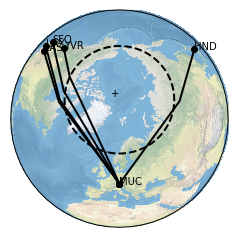

In [14]:
### make a globe and plot all the flight routes which pass through the Arctic

ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=80.0,central_longitude=origin_lon))
ax.stock_img()


plt.text(0, 90, '+',
         horizontalalignment='right',
         transform=ccrs.Geodetic())


plt.plot(np.linspace(0,359,360), np.ones(360)*arctic_circle_lat,
         color='black', linewidth=2, ls='--',
         transform=ccrs.Geodetic(),
         )

plt.text(origin_lon, origin_lat, origin, transform=ccrs.Geodetic())


for i in range(len(dest_airports)):
    if does_this_route_pass_through_arctic[i]:
        plt.plot([origin_lon,np.float(dest_airports.loc[i].lon)],
                 [origin_lat,np.float(dest_airports.loc[i].lat)],
                color='black',linewidth=2,marker='o',
                transform=ccrs.Geodetic())
        plt.text(np.float(dest_airports.loc[i].lon),np.float(dest_airports.loc[i].lat),
                dest_airports.loc[i].code,transform=ccrs.Geodetic())
        

plt.savefig(origin+'-arctic_routes.pdf',fmt='pdf')

In [15]:
print("Direct flight routes from "+origin+" that pass near the Arctic")
print("-------------------------------------------------------")
for i in range(len(does_this_route_pass_through_arctic)):
    if does_this_route_pass_through_arctic[i]:
        print(origin+'-'+dest_airports.loc[i].code)



Direct flight routes from MUC that pass near the Arctic
-------------------------------------------------------
MUC-LAX
MUC-SFO
MUC-YVR
MUC-HND
MUC-LAS


In [16]:
def get_flight_route(i):
    ### returns a pandas dataframe with the flight route info
    ### or returns None if the flight does not pass through the Arctic
    if not does_this_route_pass_through_arctic[i]:
        return None
    folderpath = '/Users/michevan/Desktop/insight/gis'
    layername = origin+'-'+dest_airports.loc[i].code
    mag_lat = [dest_airports.loc[i].code+' mag lat']; mag_lon = [dest_airports.loc[i].code+' mag lon']
    gc_lat = [dest_airports.loc[i].code+' lat']; gc_lon = [dest_airports.loc[i].code+' lon']
    with open(folderpath+'/'+layername+'.geojson') as json_file:  
        data = json.load(json_file)
        if len(data['features'][0]['geometry']['coordinates'][0]) == 2:   #if everything is working as expected
            for j in range(len(data['features'][0]['geometry']['coordinates'][:])):
                lon,lat = data['features'][0]['geometry']['coordinates'][j]
                mg_lat,mg_lon = aacgmv2.convert(lat, lon, 10, date=date.today(), 
                                                  a2g=False, trace=False, allowtrace=False,
                                                  badidea=False, geocentric=False)
                mag_lat.append(mg_lat[0])
                mag_lon.append(mg_lon[0])
                gc_lat.append(lat)
                gc_lon.append(lon)
        else:    #anti-meridian crossing, they split the results into two groups so the len will be a lot longer
            for j in range(len(data['features'][0]['geometry']['coordinates'][0][:])):
                lon,lat = data['features'][0]['geometry']['coordinates'][0][j]
                mg_lat,mg_lon = aacgmv2.convert(lat, lon, 10, date=datetime.date.today(), 
                                                  a2g=False, trace=False, allowtrace=False,
                                                  badidea=False, geocentric=False)
                mag_lat.append(mg_lat[0])
                mag_lon.append(mg_lon[0])
                gc_lat.append(lat)
                gc_lon.append(lon)
            for j in range(len(data['features'][0]['geometry']['coordinates'][1][:])):
                lon,lat = data['features'][0]['geometry']['coordinates'][1][j]
                mg_lat,mg_lon = aacgmv2.convert(lat, lon, 10, date=datetime.date.today(), 
                                                  a2g=False, trace=False, allowtrace=False,
                                                  badidea=False, geocentric=False)
                mag_lat.append(mg_lat[0])
                mag_lon.append(mg_lon[0])
                gc_lat.append(lat)
                gc_lon.append(lon)
    df = pd.DataFrame.from_records([gc_lat,gc_lon,mag_lat,mag_lon])
    return df

In [17]:
from datetime import time

def get_length_of_daytime(lat,lon,dt):
    ### returns the fraction of a 24-hour period which is daytime for a given lat,lon and a given date
    ### lat and lon should be in the form '+85.5','90'
    ### dt is the number of days in the future from today
    obs = ephem.Observer()
    obs.pressure = 0
    obs.horizon = '-12'
    obs.lat = lat
    obs.lon = lon
    obs.elevation = 10000
    d = date.today()
    h = np.int(np.floor(12.0 + np.float(lon)/15.0))
    m = np.int(np.floor(np.mod(np.float(lon)/15.0,60)))
    t = time(hour=h, minute=m)
    obs.date = datetime.combine(d+timedelta(days=dt), t)
    try:
        t1 = obs.next_setting(ephem.Sun(), use_center=True)
        t2 = obs.previous_rising(ephem.Sun(), use_center=True)
        day_frac = (t1-t2)
        if day_frac > 1:
            day_frac = day_frac - 1
    except ephem.NeverUpError:
        #print('Never Up Error')
        day_frac = 0
    except ephem.AlwaysUpError:
        #print('Always Up Error')
        day_frac = 1
    return day_frac

In [18]:
def get_yearly_daytime_fracs(lat,lon):
    ### returns the dayfracs over a one-year period for a location
    ### lat and lon should be in the form '+85.5','90'
    N = 365
    day_fracs = np.zeros(N)
    for i in range(N):
        day_fracs[i] = get_length_of_daytime(lat,lon,i)
    return day_fracs

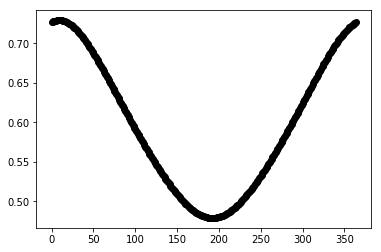

In [19]:
### just for fun, plot the yearly dayfrac for a location
fracs = get_yearly_daytime_fracs('40','90')
plt.figure()
plt.plot(np.arange(365),fracs,'-ok')

In [20]:
### make a giant dataframe that contains all the routes which pass through the arctic
### and it also contains the flight path, sampled every 10 km
### in both (lat,lon) and in magnetic (lat,lon)
N_routes = 0     #Number of routes, this will get filled in by the code
routes = pd.DataFrame(data=None)
for i in range(len(does_this_route_pass_through_arctic)):
    df = get_flight_route(i)
    if df is not None:
        routes = routes.append(df)
        N_routes += 1

In [21]:
routes

,0,1,2,3,4,5,6,7,8,9,...,956,957,958,959,960,961,962,963,964,965
0,LAX lat,48.353889,48.423371,48.492788,48.562140,48.631426,48.700647,48.769801,48.838889,48.907910,...,34.639993,34.562598,34.485178,34.407730,34.330257,34.252757,34.175232,34.097680,34.020103,33.942500
1,LAX lon,11.786111,11.700427,11.614509,11.528356,11.441967,11.355342,11.268479,11.181377,11.094035,...,-117.909012,-117.964871,-118.020627,-118.076280,-118.131830,-118.187279,-118.242625,-118.297871,-118.353015,-118.408060
2,LAX mag lat,43.234213,43.316555,43.398854,43.481110,43.563323,43.645493,43.727620,43.809703,43.891743,...,40.657576,40.569607,40.481633,40.393654,40.305670,40.217682,40.129690,40.041694,39.953694,39.865690
3,LAX mag lon,87.098347,87.038310,86.978173,86.917937,86.857599,86.797161,86.736620,86.675976,86.615229,...,-51.530679,-51.576021,-51.621183,-51.666165,-51.710970,-51.755597,-51.800048,-51.844323,-51.888425,-51.932354
0,SFO lat,48.353889,48.427697,48.501452,48.575155,48.648805,48.722401,48.795943,48.869432,48.942866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SFO lon,11.786111,11.709182,11.632030,11.554653,11.477052,11.399224,11.321169,11.242886,11.164373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SFO mag lat,43.234213,43.321989,43.409724,43.497418,43.585070,43.672680,43.760249,43.847775,43.935260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SFO mag lon,87.098347,87.046800,86.995165,86.943441,86.891627,86.839723,86.787728,86.735642,86.683462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,YVR lat,48.353889,48.432792,48.511658,48.590486,48.669276,48.748029,48.826742,48.905418,48.984054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,YVR lon,11.786111,11.721494,11.656676,11.591657,11.526435,11.461010,11.395380,11.329544,11.263501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#### get the highest magnetic latitude for each route
def get_mag_lat_maxes(routes,N_routes):
    ilocs = 2+np.arange(N_routes)*4
    maxes = np.zeros(N_routes)
    for i in range(N_routes):
        maxes[i] = routes.iloc[ilocs[i]][1:].max()
    return maxes

In [23]:
### print the highest magnetic latitude for each route
mag_lat_maxes = get_mag_lat_maxes(routes,N_routes)
print(mag_lat_maxes)

[ 70.77731141  73.95205996  78.07301091  61.19241307  69.96507797]


In [24]:
def get_one_day_aurora_prob(lat,lon,mag_lat,mag_lon,dt,mag_lats,kpX_aurora_prob):
    ### for a given flight route (lat,lon,mag_lat,mag_lon) output the probability of seeing 
    ### the aurora. 
    ### mag_lats and kpX_aurora_prob are matching arrays giving the model
    ### probability of seeing the aurora over a 4-hour period at a given mag latitude 
    ### (see get_aurora_prob_over_time for details)
    ### dt = number of days from today
    v_airplane = 600.0  #km/hr
    dl = 10 #km
    N_pts = len(lat)
    probs = np.zeros(N_pts)
    for i in range(N_pts):
        if np.isnan(lat[i]):
            continue
        day_frac = get_length_of_daytime(str(lat[i]),str(lon[i]),dt)
        aur_frac = np.interp(mag_lat[i],mag_lats,kpX_aurora_prob)
        probs[i] = (1.0-day_frac) * aur_frac * (dl / v_airplane / 4.0)
    return 1.0 - np.prod(1.0 - probs)

In [25]:
### example of calling get_one_day_aurora_prob
#mag_lats = np.linspace(50,90,401)
#kp1_aurora_prob = (mag_lats>64.5)*0.5     # over 4 hours
#
#p = get_one_day_aurora_prob(routes.iloc[0][1:].values,routes.iloc[1][1:].values,
#                    routes.iloc[2][1:].values,routes.iloc[3][1:].values,180,mag_lats,kp1_aurora_prob)
#print(p)

In [26]:
### load up the aurora data which I downloaded from NOAA
### FTP link available at https://www.ngdc.noaa.gov/stp/geomag/kp_ap.html
def get_aurora_data():
    fnames = np.linspace(1932,2018,87).astype(int)
    time_list = []
    kp_list = []
    ap_list = []
    for i in range(87):
        with open('/Users/michevan/Desktop/insight/noaa/'+str(fnames[i]),'r') as file:
            for line in file: 
                year = np.int(fnames[i])
                month = np.int(line[2:4])
                day = np.int(line[4:6])
                mydate = date(year,month,day)
                day_count = mydate.strftime("%j")
                time_list.append(year+np.float(day_count)/365.+0.0625/365)
                kp_list.append(np.int(line[12:14]))
                ap_list.append(np.int(line[31:34]))
                time_list.append(year+np.float(day_count)/365.+0.1875/365)
                kp_list.append(np.int(line[14:16]))
                ap_list.append(np.int(line[34:37]))
                time_list.append(year+np.float(day_count)/365.+0.3125/365)
                kp_list.append(np.int(line[16:18]))
                ap_list.append(np.int(line[37:40]))
                time_list.append(year+np.float(day_count)/365.+0.4375/365)
                kp_list.append(np.int(line[18:20]))
                ap_list.append(np.int(line[40:43]))
                time_list.append(year+np.float(day_count)/365.+0.5625/365)
                kp_list.append(np.int(line[20:22]))
                ap_list.append(np.int(line[43:46]))
                time_list.append(year+np.float(day_count)/365.+0.6875/365)
                kp_list.append(np.int(line[22:24]))
                ap_list.append(np.int(line[46:49]))
                time_list.append(year+np.float(day_count)/365.+0.8125/365)
                kp_list.append(np.int(line[24:26]))
                ap_list.append(np.int(line[49:52]))
                time_list.append(year+np.float(day_count)/365.+0.9375/365)
                kp_list.append(np.int(line[26:28]))            
                ap_list.append(np.int(line[52:55]))
    kp = pd.Series(kp_list,index=time_list)
    ap = pd.Series(ap_list,index=time_list)
    return kp,ap

In [27]:
### put the aurora data into pandas dataframes
### I will actually only use the ap data
### and I think there is something wrong with how I am parsing the kp data
kp,ap = get_aurora_data()

In [28]:
### smooth the ap data
ap_smooth = ap.rolling(240).mean()  #3-day smoothing


In [29]:
### fit a 4th-order function to the data for the current Solar cycle
cycle_begin = 2008.01   #Jan 4, 2008
cycle_end = 11.0 + cycle_begin
print(cycle_end)
x = np.array(ap.index)
y = ap_smooth.values
filter = np.where((x > cycle_begin)*(x<cycle_end))
y = y[filter]
x = x[filter]
z = np.polyfit(x-2013., y, 4)
p = np.poly1d(z)
x_model = np.linspace(cycle_begin,cycle_end+0.6,1001)
bf_model = p(x_model-2013.)

2019.01


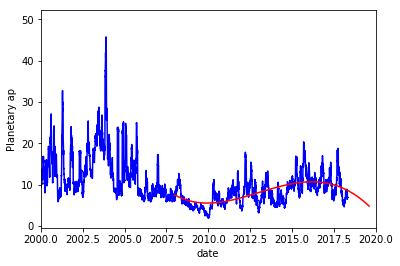

In [30]:
### plot the model
plt.figure()
plt.plot(ap.index,ap_smooth.values,'-b')
plt.plot(x_model,bf_model,'-r')
plt.xlim([2000,2020])
plt.ylabel('Planetary ap')
plt.xlabel('date')
plt.savefig('planetary_ap.pdf')


In [31]:
### aurora prob lookup table (from https://www.ngdc.noaa.gov/stp/geomag/kp_ap.html)
### to convert ap values into kp values
kp_lookup = np.array([0,0.33,0.67,1.0,1.33,1.67,2.0,2.33,2.67,3.0,3.33,3.67,4.0,4.33,4.67,5.0,5.33,5.67,6.0,6.33,6.67])
ap_lookup = np.array([0,2,3,4,5,6,7,9,12,15,18,22,27,32,39,48,56,67,80,94,111])
kp_model = np.interp(bf_model,ap_lookup,kp_lookup)

In [32]:
def get_aurora_prob_over_time(lat,lon,mag_lat,mag_lon,x_model,kp_model,N_days=31,day_max=300):
    ### get probability of seeing aurora for a given flight path, over the next day_max days
    ### N_days is the number of days to sample within the day_max-day window
    ### lat,lon,mag_lat,mag_lon are the flight path info
    ### x_model and kp_model are matching arrays showing my model prediction for the average 
    ### Kp for the rest of the aurora cycle
    ###
    ###
    ### here is where I put my aurora model itself
    mag_lats = np.linspace(50,90,401)
    kp0_aurora_prob = (mag_lats>66.5)*0.4     # over 4 hours
    kp1_aurora_prob = (mag_lats>64.5)*0.5     # over 4 hours
    kp2_aurora_prob = (mag_lats>62.4)*0.6     # over 4 hours
    kp3_aurora_prob = (mag_lats>60.4)*0.7     # over 4 hours
    kp4_aurora_prob = (mag_lats>58.3)*0.8     # over 4 hours
    kp5_aurora_prob = (mag_lats>56.3)*0.9     # over 4 hours
    ### based on https://www.swpc.noaa.gov/content/tips-viewing-aurora
    ### and fig 12-20b of http://www.cnofs.org/Handbook_of_Geophysics_1985/Chptr12.pdf
    dts = np.linspace(0,day_max,N_days)
    p_aurora = np.zeros(N_days)
    for i in range(N_days):
        print(i)
        date_today = date.today() +timedelta(days=dts[i])
        year_code = date_today.year+date_today.month/12.0 +date_today.day/365.0
        kp_prediction = np.interp(year_code,x_model,kp_model)
        if kp_prediction < 0.5:
            kpX_aurora_prob = kp0_aurora_prob
        elif kp_prediction < 1.5:
            kpX_aurora_prob = kp1_aurora_prob
        elif kp_prediction < 2.5:
            kpX_aurora_prob = kp2_aurora_prob
        elif kp_prediction < 3.5:
            kpX_aurora_prob = kp3_aurora_prob
        else:
            kpX_aurora_prob = kp4_aurora_prob
        p = get_one_day_aurora_prob(lat,lon,mag_lat,mag_lon,dts[i],mag_lats,kpX_aurora_prob)
        p_aurora[i] = p
    return p_aurora,dts

In [33]:
N_days = 31
aurora_p = np.zeros([N_days,N_routes])
for i in range(N_routes):
    print(i)
    p,dts = get_aurora_prob_over_time(routes.iloc[4*i][1:].values,
                                      routes.iloc[4*i+1][1:].values,
                                      routes.iloc[4*i+2][1:].values,
                                      routes.iloc[4*i+3][1:].values,
                                      x_model,kp_model)
    aurora_p[:,i] = p


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


(0, 1)

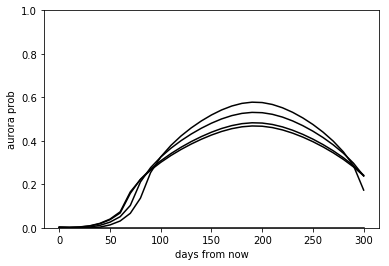

In [34]:
plt.figure()
plt.clf()
for i in range(N_routes):
    plt.plot(dts,aurora_p[:,i],'-k')
plt.xlabel('days from now')
plt.ylabel('aurora prob')
plt.ylim(0,1)